In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reset -sf

In [ ]:
#### import importlib
import Deproject_v1_0 
from Deproject_test import *
from Deproject_plots import DM_plt_prefs
DM_plt_prefs()
import matplotlib.pyplot as plt
import os
import cProfile
import numpy as np
import builtins
from scipy import sparse as scisp
from scipy import optimize as sopt
from scipy.ndimage import zoom
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from timeit import default_timer as timer
from fast_kde import fast_kde

from astropy.io.ascii import read as tableread
import astropy.units as u
import astropy.coordinates as coord
np.random.seed(0)
coord.Galactic()
%cd ~/Documents/DeprojectionProject/

In [ ]:
%cd faststats/faststats/
from fkde import *
def kdeplot(x,y,grid,no_c,bw_a):
    Z,ax = fastkde(x,y,gridsize=grid,nocorrelation=no_c,adjust=bw_a)#,weights,adjust)
    xlen,ylen = np.shape(Z)
    X,Y = np.meshgrid(np.linspace(ax[0],ax[1],xlen),np.linspace(ax[0],ax[1],ylen))
    return X,Y,Z
%cd ~/Documents/DeprojectionProject/

In [ ]:
def rot(x,y,deg):
    xf = x.flatten(); xf = xf.reshape(len(xf),1)
    yf = y.flatten(); yf = yf.reshape(len(yf),1)
    pos = np.hstack((xf,yf))
    
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    pos = np.dot(pos, R.T)
    
    x = pos[:,0].reshape(x.shape)
    y = pos[:,1].reshape(y.shape)
    return x,y

def f(x,y,z,lim):
    x,y = rot(x,y,45)
    val = (lim-np.abs(x))**4 + (lim-np.abs(y))**4 + (lim-np.abs(z))**4
    return val/np.sum(val)


def pyramid_sample(N_sample,r,c):
    # Velocities
    xc,yc,zc = c
    N = 100
    X = np.linspace(-r,r,N)
    Y = np.linspace(-r,r,N)
    Z = np.linspace(-r,r,N)
    
    XX = X.reshape(1,N,1)*np.ones((N,1,N))
    YY = Y.reshape(N,1,1)*np.ones((1,N,N))
    ZZ = Z.reshape(1,1,N)*np.ones((N,N,1))
    
    P = f(XX,YY,ZZ,r+np.max(c))
    
    rrind = np.ravel_multi_index(np.indices(XX.shape), XX.shape).ravel()
    prob = np.ravel(P)
    smp = np.random.choice(rrind, size=N_sample, p=prob)
    smpx, smpy, smpz = np.asarray(np.unravel_index(smp, XX.shape))
    
    XX = XX + xc
    ZZ = YY + yc
    YY = ZZ + zc
    
    vxvals = XX[smpx, smpy, smpz]
    vyvals = YY[smpx, smpy, smpz]
    vzvals = ZZ[smpx, smpy, smpz]
    
    # Positions
    xmax, ymax, zmax = np.array([100,100,100])/np.sqrt(3)    
    xmin, ymin, zmin = -xmax,-ymax,-zmax
    
    xvals = (np.random.rand(N_sample) * (xmax - xmin) + xmin)
    yvals = (np.random.rand(N_sample) * (ymax - ymin) + ymin)
    zvals = (np.random.rand(N_sample) * (zmax - zmin) + zmin)
    return xvals, yvals, zvals, vxvals, vyvals, vzvals

## Generate gaussian sample

In [ ]:
N = 5000 #Number of stars we want to use in our sample
sample, vx, vy, vz = Deproject_v1_0.model_sample(N)

pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Generate pyramid-like sample from distribution

In [ ]:
x, y, z, vx, vy, vz = pyramid_sample(int(1e4),100, c=(0,0,0))

In [ ]:
x,y,z          = (x,y,z)* u.pc
vx,vy,vz       = (vx,vy,vz) * (u.km / u.s)

In [ ]:
# We use Astropy's coord class which makes it easy to keep track of units and conversions

sample = coord.Galactic(u=x,
                         v=y, 
                         w=z,
                         U=vx,
                         V=vy,
                         W=vz,
                         representation_type=coord.CartesianRepresentation,
                         differential_type=coord.CartesianDifferential)
sample.set_representation_cls(coord.SphericalRepresentation, coord.SphericalCosLatDifferential)



In [ ]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Generate  fake Galactic samples

From simulated galaxy:

Loading data

In [ ]:
N = 5000 #Number of stars we want to use in our sample
dat = np.load('DATA/simgal.npy')

Select a sample around with radius 2 kpc around 8 kpc

In [ ]:
x,y,z,vx,vy,vz = dat
R = np.sqrt((x-8)**2 + y**2)
snbh = R < 2
dat = dat[:,snbh]
I = np.random.randint(low=0,high=np.sum(snbh),size=N)

x,y,z,vx,vy,vz = dat[:,I]

# Center x, y and vy, so they look like they're relative to the LSR
x = x - np.median(x)
y = y - np.median(y)
vy = vy - np.median(vy)

Prepare for astropy

In [ ]:
x,y,z          = (x,y,z)* u.pc
vx,vy,vz       = (vx,vy,vz) * (u.km / u.s)

In [ ]:
# We use Astropy's coord class which makes it easy to keep track of units and conversions

sample = coord.Galactic(u=x,
                         v=y, 
                         w=z,
                         U=vx,
                         V=vy,
                         W=vz,
                         representation_type=coord.CartesianRepresentation,
                         differential_type=coord.CartesianDifferential)
sample.set_representation_cls(coord.SphericalRepresentation, coord.SphericalCosLatDifferential)


In [ ]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Inspect sample

In [ ]:
plt.hist2d(np.array(sample.l),np.array(sample.b),100)
plt.show()

In [ ]:
n = np.array([20,20,20])
dv = np.array([10,10,10])
vmin = np.array([-100,-100,-100])

alpha_guess = 1e-8
v_guess = np.array([1,1,1])
disp_guess = np.array([22,17,30])

In [ ]:
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

sigma = np.sqrt(sigma2)
phi0 = phi_guess(vmean0,sigma,vmin,dv,n)

sanity_check(pvals,rhatvals,phi0,vmin,dv,n)

In [ ]:
t0 = timer()
mxl, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess)
time = str((timer() - t0)/60); print(time + ' mins')

sanity_check(pvals,rhatvals,mxl,vmin,dv,n)

In [ ]:
# L, gradL             - For each fmin_cg iteration
# L_calls, gradL_calls - For each function and gradient call respectively
# I_its, Ig_its        - Indices of L_calls and gradL_calls that match the iterations

def plot_LanddL():
    I_its = []
    Ig_its = []

    for i, call in enumerate(L_calls):
        if call in L:
            I_its.append(i)
    
    for i, call in enumerate(gradL_calls):
        if call in gradL:
            Ig_its.append(i)


    f,ax = plt.subplots(2,2,figsize=(14,10),sharey='row',frameon=False,gridspec_kw={'height_ratios':[3,1]})

    ax[0,0].set_title('All iterations\n$\\nabla\mathscr{L}(\\varphi)$')
    ax[0,0].plot(gradL_calls[Ig_its],'k-',marker='.',linewidth=1)
    ax[0,0].set_yscale('log')

    ax[1,0].set_title('$\mathscr{L}(\\varphi)$')
    ax[1,0].plot(L_calls[I_its],'k-',marker='.',linewidth=1)
    ax[1,0].set_xlabel('Iterations')

    ax[0,1].set_title('All calls\n $\\nabla\mathscr{L}(\\varphi)$')
    ax[0,1].plot(gradL_calls,'r-',linewidth=1)
    ax[0,1].plot(Ig_its,gradL_calls[Ig_its],'k.')
    ax[0,1].set_yscale('log')
    ax[0,1].set_ylim(gradL_calls.min()*0.1, gradL_calls.max()*1.1)

    # inset axes....
    axins = ax[0,1].inset_axes([0.05, 0.01, 0.90, 0.3])
    axins.plot(gradL_calls,'r-',marker='.',linewidth=1,label='$\\nabla\mathscr{L}(\\varphi)$ calls')
    axins.plot(Ig_its,gradL_calls[Ig_its],'k.',label='$\mathrm{\\tt fmin\_cg()}}$ iterations')

    # sub region of the original image
    x1, x2, y1, y2 = Ig_its[-10], len(gradL_calls), 0.9*gradL_calls[Ig_its[-10]:].min(), 1.1*gradL_calls[Ig_its[-10]:].max()
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_yticklabels('')
    axins.set_xticks([x1,x2])
    axins.xaxis.tick_top()
    #axins.legend(fontsize=14)
    ax[0,1].indicate_inset_zoom(axins)



    ax[1,1].set_title('$\mathscr{L}(\mathscr{\phi})$')
    ax[1,1].plot(L_calls,'r-',linewidth=1,label='$\mathscr{L}(\\varphi)$ calls')
    ax[1,1].plot(I_its,L_calls[I_its],'k.',label='$\mathrm{\\tt fmin\_cg()}}$ iterations')
    ax[1,1].set_xlabel('function calls')
    ax[1,1].legend(fontsize=14)
    plt.show()
    return 

# End of non-testing lines

In [ ]:
N = 5000 #Number of stars we want to use in our sample
sample, vx, vy, vz = Deproject_v1_0.model_sample(N)

pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)
sigma = np.sqrt(sigma2)

n = np.array([0,20,20])
dv = np.array([10,10,10])
vmin = np.array([-100,-100,-100])

alpha_guess = 1e-9
v_guess = np.array([1,1,1])
disp_guess = np.array([22,17,30])

Kvals = KvalsNumpyMethod(pvals, rhatvals, vmin, dv, n)

nx, ny, nz = n
phi0 = phi_guess(vmean0,sigma,vmin,dv,n)  
phi0r = np.ravel(phi0)

args = (Kvals, N, alpha_guess, dv, n, sigma2)

In [ ]:
print('Started fmin_cg... ',end='')
mxl, fopt, fcalls, gcalls, flag, phi_all = fmin_cg(neg_L_calc, phi0r, fprime=grad_neg_L_calc, gtol=1e-8, args=args, retall=True, disp=False, full_output=True)
print(colored('Finished!','green',attrs=['bold','underline']))
fmin_it = np.shape(phi_all)[0] - 1
fmin_cg_output(fopt, fcalls, gcalls, flag, fmin_it)

In [ ]:
def sample_calc(datafile):
    os.chdir("/home/mikkola/Documents/DeprojectionProject/DATA")
    data_raw = tableread(str(datafile))
    os.chdir("/home/mikkola/Documents/DeprojectionProject")
    
    dist = 1000/data_raw['parallax']*u.pc        
    RA = (data_raw['ra']*u.degree)
    DEC = (data_raw['dec']*u.degree)
    plx = (data_raw['parallax']*u.mas)
    pm_RA = (data_raw['pmra']*u.mas/u.yr)
    pm_DEC = (data_raw['pmdec']*u.mas/u.yr)
    print("Sample has " + str(len(dist)) + " stars\n")

    sample_icrs = coord.ICRS(ra = RA, dec = DEC, pm_ra_cosdec = pm_RA, pm_dec = pm_DEC,distance=dist)

    sample = sample_icrs.transform_to(coord.Galactic)


    pvals, rhatvals = calc_p_rhat(sample) 
    return pvals, rhatvals

def get_args(pvals, rhatvals, phi0, vmean0, alpha_guess, sigma, vmin, dv, n):
    Kvals = KvalsNumpyMethod(pvals, rhatvals, vmin, dv, n)  
    phi0r = np.ravel(phi0)
    args = (Kvals, N, alpha_guess, dv, n, sigma**2)
    return args, phi0r

def get_kvals(pvals, rhatvals, vmin, dv, n):
    Kvals = KvalsNumpyMethod(pvals, rhatvals, vmin, dv, n)  
    return Kvals

In [ ]:
def callback_mg(x):
    i = builtins.grid_step
    builtins.L[i].append(builtins.current_L)
    builtins.gradL[i].append(builtins.current_gradL)
    
def callback(x):
    builtins.L.append(builtins.current_L)
    builtins.gradL.append(builtins.current_gradL)

def max_L(alpha, pvals, rhatvals, vmin, dv, n, phi0_guess=[], v0_guess=[], disp_guess=[], noniso=False, printing=True):
    """Function that employs scipy.optimize.fmin_cg to maximise the function get_neg_L().
    It takes guesses of the distribution (currently only supports Gaussian guesses) and the relevant data from the
    star sample for which the velocity distribution is to be estimated."""
    
    builtins.L     = []
    builtins.gradL = [] 
    
    dvx, dvy, dvz = dv
    nx, ny, nz = n
    N = len(pvals)
    
    sigma2, vmean = calc_sigma2(pvals, rhatvals, True, noniso=noniso)
    if np.size(v0_guess) == 0:
        v0_guess = vmean
    if np.size(disp_guess) == 0:
        sigma = np.sqrt(sigma2)
        disp_guess = sigma
    if np.size(phi0_guess) == 0:
        phi0 = phi_guess(v0_guess, disp_guess, vmin, dv,n)
    else:
        phi0 = phi0_guess
     
    Kvals_args = (pvals, rhatvals, vmin, dv, n, N, printing)
    Kvals = Kvals_function_selector(Kvals_args)

    args = (Kvals, N, alpha, dv, n, sigma2)
    phi0r = np.ravel(phi0)  # fmin_cg only takes one-dimensional inputs for the initial guess
    
    print('Started fmin_cg... ',end='')
    
    builtins.L.append(-1*get_neg_L(phi0r,Kvals, N, alpha, dv, n, sigma2))
    builtins.gradL.append(np.linalg.norm(get_grad_neg_L(phi0r,Kvals, N, alpha, dv, n, sigma2)))
        
    mxl, fopt, fcalls, gcalls, flag, phi_all = fmin_cg(get_neg_L, phi0r, fprime=get_grad_neg_L, gtol=1e-6, args=args, retall=True, disp=False, full_output=True, callback=callback)
    print(colored('Finished!','green',attrs=['bold','underline']))
    
    fmin_it = np.shape(phi_all)[0] - 1
    fmin_cg_output(fopt, fcalls, gcalls, flag, fmin_it)
                
        
    mxlnew = mxl.reshape(n)
    return mxlnew, fmin_it, phi_all
    
def multigrid_max_L(alpha, pvals, rhatvals, vmin, dv, n, phi0_guess=[], v0_guess=[], disp_guess=[], noniso=False, printing=False):
    """Function that employs scipy.optimize.fmin_cg to maximise the function get_neg_L().
    It takes guesses of the distribution (currently only supports Gaussian guesses) and the relevant data from the
    star sample for which the velocity distribution is to be estimated.
    
    This function differs from max_L() in that it starts with a crude box (nx,ny,nz) and itertively increases size 
    to reach the final box size. This will significantly improve runtime"""
    
    N = len(pvals)
    vmax = vmin + dv*n
    
    box_steps = multigrid_steps(n)
    
    n = box_steps[0]
    dv = (vmax-vmin)/n
    
    sigma2, vmean = calc_sigma2(pvals, rhatvals, True, noniso=noniso)
    if np.size(v0_guess) == 0:
        v0_guess = vmean
    if np.size(disp_guess) == 0:
        sigma = np.sqrt(sigma2)
        disp_guess = sigma
    if np.size(phi0_guess) == 0:
        phi0 = phi_guess(v0_guess, disp_guess, vmin, dv,n)
    else:
        phi0 = phi0_guess
        
    builtins.L     = [[] for _ in range(len(box_steps))]
    builtins.gradL = [[] for _ in range(len(box_steps))]
    fmin_it = 0
    for grid_step,n in enumerate(box_steps): 
        if grid_step == len(box_steps)-1:
            printing = True
        builtins.grid_step = grid_step    
        dv = (vmax-vmin)/n
            
        Kvals_args = (pvals, rhatvals, vmin, dv, n, N, printing)
        Kvals = Kvals_function_selector(Kvals_args)
        
        args = (Kvals, N, alpha, dv, n, sigma2)
        phi0r = np.ravel(phi0)  # fmin_cg only takes one-dimensional inputs for the initial guess
        
        ### This is where the minimization occurs
        print('Started fmin_cg on (%s, %s, %s) grid... ' % (n[0],n[1],n[2]),end='', flush=True)
        builtins.L[grid_step].append(-1*get_neg_L(phi0r,Kvals, N, alpha, dv, n, sigma2))
        builtins.gradL[grid_step].append(np.linalg.norm(get_grad_neg_L(phi0r,Kvals, N, alpha, dv, n, sigma2)))

        mxl, fopt, fcalls, gcalls, flag, phi_all = fmin_cg(get_neg_L, phi0r, fprime=get_grad_neg_L, gtol=1e-6, args=args, retall=True, disp=False, full_output=True, callback=callback_mg)
        fmin_it += np.shape(phi_all)[0] - 1   
        
        print(colored('Finished!','green',attrs=['bold','underline']),end='')
        print(' fopt : %s' % fopt)
        ##########################################
        
        if grid_step == len(box_steps)-1:
            fmin_cg_output(fopt, fcalls, gcalls, flag, fmin_it)
        else:
            phi0 = zoomed_mxl(mxl.reshape(n))

    mxlnew = mxl.reshape(n)
    return mxlnew, fmin_it, phi_all

# @profile
def get_grad_neg_L(phi, *args):
    """In this function we compute the gradient of L. We compute the derivative for each cell and return a
    1D array of length (nx*ny*nz).

    args: see get_L

    """
    Kvals, N, alpha, dv, n, sigma2 = args
    
    
    exphir = np.exp(phi)
    exphi_csc = scisp.coo_matrix(exphir).tocsc()
    
    Kphi = exphi_csc.multiply(Kvals)
    Kphi_sum = Kphi.sum(axis=1)
    Kphi_sum[Kphi_sum.nonzero()] = 1 / Kphi_sum[Kphi_sum.nonzero()] # We compute the sum of exp(phi)*K(k|l) for each star
    K_term0 = Kphi.multiply(Kphi_sum)
    K_term = K_term0.sum(axis=0) # The final array with the first term for each cell
    
    phi_unr = np.reshape(phi,n)
    dphixhi = grad_sec_der(phi_unr, sigma2, dv)   
    
    t1 = K_term/N
    t2 = exphi_csc
    t3 = ((alpha * dv[0] * dv[1] * dv[2]) / 2) * dphixhi.ravel()
    
    grad_L = np.asarray(t1 - t2 - t3).reshape(len(phi), )
    
    neg_grad_L = -1 * grad_L
    builtins.current_gradL = np.linalg.norm(neg_grad_L)
    return neg_grad_L

def get_neg_L(phi, *args):
    """The function that we wish to optimise. Corresponds to eq. 31 in D98.

    N: Number of stars in our sample

    Kvals: Array of dimensions (N,nx,ny,nz) containing the K-values for each star in our sample.

    alpha: Smoothing parameter that can be found using the function opt_alpha
   
    We use sparse matrices in our computation of L_tilde because our K- arrays have low
    density. Therefore we use the scipy.sparse package to convert our arrays to sparse arrays.
    Using coo-matrices is faster when building the matrix, but the csc-matrices are faster for
    arithmetic operations
    
    phi_unr regains the original shape of our phi guess and is used to compute the
    third term of L_tilde."""
    
    Kvals, N, alpha, dv, n, sigma2 = args
    
    exphir = np.exp(phi)
    exphi_csc = scisp.coo_matrix(exphir).tocsc()
    Kphi = Kvals.multiply(exphi_csc).sum(axis=1) # Order all Kphi values in 1D arrays and compute the sum of exp(phi)*K(k|l) for each star
    Kphi_sum_tot = np.log(Kphi[Kphi != 0]).sum() # To make sure we don't get infinities and .sum() gives the double sum in the first term
    
    phi_unr = np.reshape(phi, n)
    phixhi_sum = (sec_der(phi_unr, sigma2, dv) ** 2).sum()
    
    t1 = Kphi_sum_tot / N
    t2 = exphi_csc.sum()
    t3 = ((alpha * dv[0] * dv[1] * dv[2]) / 2) * phixhi_sum
    
    L_tilde = t1 - t2 - t3 # eq. 31 in DB98
        
    neg_L = -1 * L_tilde  # Since we want to maximize L_tilde, we should minimize -L_tilde
    builtins.current_L = L_tilde
    return neg_L

In [ ]:
# Number of stars
N = 10000

# Number of bins
n = np.array([96,96,96])

# Minimum cartesian velocities
vmin = np.array([-100,-140,-50])

# Bin sizes
dv = np.array([4,4,2])

# Use guess|DB89 = 1|0
use_guess = bool(1)

# Use non-isotropic DB89 = 1|0
non_iso = bool(1)

# Mu guess
v_guess = np.array([3,-10,-2])

# Sigma guess
disp_guess = np.array([30,20,15])

# Alpha smoothing parameters
alpha = 1.00000000e-10

# Filename of data, for pseudodata set blank
datafile = 'wd_sample.table'

# Do you want to log this run (Produce logfiles and save plots)? 1|0
logging = bool(0)

In [ ]:
pvals, rhatvals = sample_calc(datafile)

In [ ]:
ti_a = time.time()
mxl, fmin_it, phi_all = multigrid_max_L(alpha, pvals, rhatvals, vmin, dv, n ,v0_guess=v_guess, disp_guess=disp_guess, noniso=non_iso)
tf_a = time.time()
endtime = (tf_a - ti_a)/60
print("\nThe run took: ", endtime, 'mins')
L_mg        = builtins.L
gradL_mg    = builtins.gradL


ti_a = time.time()
mxl, fmin_it, phi_all = max_L(alpha, pvals, rhatvals, vmin, dv, n ,v0_guess=v_guess, disp_guess=disp_guess, noniso=non_iso)
tf_a = time.time()
endtime = (tf_a - ti_a)/60
print("\nThe run took: ", endtime, 'mins')
L        = builtins.L
gradL    = builtins.gradL

In [ ]:
s1 = 'vals'.ljust(10) + 'max_L'.ljust(7) + 'mg_max_L'
s2 = 'L'.ljust(7) + ':'.ljust(3) + str(len(L)).ljust(7) + str(len(L_mg[0] + L_mg[1] + L_mg[2]))
s3 = 'Grad L'.ljust(7) + ':'.ljust(3) + str(len(gradL)).ljust(7) + str(len(gradL_mg[0] + gradL_mg[1] + gradL_mg[2]))
print(s1)
print(s2)
print(s3)

In [ ]:

np.arange

plt.figure()

plt.plot(np.arange(1,L1), L_mg[0],label='(12, 12, 12)')
plt.plot(np.arange(L1+1,L2), L_mg[1],label='(24, 24, 24)')
plt.plot(np.arange(L2+1,L3), L_mg[2],label='(48, 48, 48)')
plt.plot(np.arange(L3+1,L4), L_mg[3],label='(96, 96, 96)')
plt.plot(np.arange(1,len(L)+1),np.array(L),'k', label='max_L')
        
plt.legend(fontsize=12)
plt.ylabel('L')
plt.xlabel('Iterations')
plt.xscale("log")

# inset axes....
axins = plt.gca().inset_axes([0.25, 0.45, 0.70, 0.35])
axins.plot(np.arange(1,L1), L_mg[0],label='(12, 12, 12)')
axins.plot(np.arange(L1+1,L2), L_mg[1],label='(24, 24, 24)')
axins.plot(np.arange(L2+1,L3), L_mg[2],label='(48, 48, 48)')
axins.plot(np.arange(L3+1,L4), L_mg[3],label='(96, 96, 96)')
axins.plot(np.arange(1,len(L)+1),np.array(L),'k', label='max_L')
    
# sub region of the original image
x1, x2, y1, y2 = 1, L4, -15, -9.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_yticklabels('')
axins.set_xticks([x1,x2])
#axins.xaxis.tick_top()
axins.set_xscale("log")
#axins.legend(fontsize=14)
plt.gca().indicate_inset_zoom(axins)

plt.show()

In [ ]:
gradL = gradL_mg
L = L_mg


mg_string = "Iterations per grid:\n" + " -> ".join([str(len(L)) for L in L_mg])

print(mg_string)

In [ ]:
any(isinstance(el, list) for el in L)

In [ ]:

L = L_mg
print(any(isinstance(entry, list) for entry in L))
L = sum(L,[])
print(any(isinstance(entry, list) for entry in L))

In [1]:
gradL = gradL_mg
L = L_mg

mg_string = "Iterations per grid:\n" + " -> ".join([str(len(L)) for L in L_mg])

L = sum(L,[])
gradL = sum(gradL,[])

f,ax = plt.subplots(2,1,figsize=(7,9),sharex=True,frameon=False,gridspec_kw={'height_ratios':[3,1]})

ax[0].plot(range(1,len(gradL)+1),gradL,'k-',linewidth=2)

ax[0].set_yscale('log')
ax[0].set_ylabel('$|\\nabla\\widetilde{\mathscr{L}}_\\alpha(\\varphi)|$')

bbox_props = dict(boxstyle="square", fc="white", ec="k", lw=1)
ax[0].text(0.012,1.02, mg_string, transform=ax[0].transAxes,fontsize=14, bbox=bbox_props)

ax[1].set_ylabel('$\mathscr{L}_\\alpha(\\varphi)$')
ax[1].plot(range(1,len(L)+1),L,'k-',linewidth=2)
ax[1].set_xlabel('Iterations')
ax[1].set_xscale('log')
plt.subplots_adjust(hspace=0.02)

NameError: name 'gradL_mg' is not defined

In [ ]:
plt.figure()

start = 0
for ni,grid_gradL in enumerate(gradL_mg):
    x = np.arange(start, start + len(grid_gradL), 1)
    start += len(x)
    label='(%s, %s, %s)' % tuple([12*2**(ni)]*3)
    plt.plot(x, np.array(grid_gradL),label=label)
#plt.plot(gradL,'k', label='max_L')
    
plt.legend(fontsize=11, loc='upper center')
plt.ylabel('$\\nabla$L')
plt.xlabel('Iterations')
plt.yscale("log")
plt.xscale("log")

plt.show()

In [ ]:
L[0][:5]

In [ ]:
extL[:5]

In [ ]:
multigrid_steps(np.array([25,25,25]))

In [ ]:
n = np.array([25,25,25])
sigma2, vmean = calc_sigma2(pvals, rhatvals, True, noniso=non_iso)
vmax = vmin + dv*n
N = len(pvals)

In [ ]:
n = np.array([12,12,12])
dv = (vmax-vmin)/n

phi = phi_guess(v_guess, disp_guess, vmin, dv,n)
phi = phi.ravel()
Kvals = KvalsNumpyMethod(pvals, rhatvals, vmin, dv, n)
get_neg_L(phi,Kvals, N, alpha, dv, n, sigma2)

In [ ]:
phi2 = zoom(phi.reshape(12,12,12), zoom=2, order=5) - np.log(8)
phi2 = phi2.ravel()
n = np.array([24,24,24])
dv = (vmax-vmin)/n
Kvals = KvalsNumpyMethod(pvals, rhatvals, vmin, dv, n)
get_neg_L(phi2,Kvals, N, alpha, dv, n, sigma2)

In [ ]:
phi2 = zoom(phi.reshape(12,12,12), zoom=2, order=3) - np.log(8)
phi2 = phi2.ravel()
n = np.array([24,24,24])
dv = (vmax-vmin)/n
Kvals = KvalsNumpyMethod(pvals, rhatvals, vmin, dv, n)
get_neg_L(phi2,Kvals, N, alpha, dv, n, sigma2)

In [ ]:
phi2 = zoom(phi.reshape(12,12,12), zoom=2, order=3)

In [ ]:


np.exp(phi).sum(), np.exp(phi2-np.log(8)).sum(), (np.exp(phi2)/8).sum()

In [6]:
import pickle
import numpy as np

In [2]:
with open('vars.txt', 'rb') as f:
    var_load = pickle.loads(f.read())

In [4]:
pvals, rhatvals, vmin, dv, n, Nblock = var_load['pvals'], var_load['rhat'], var_load['vmin'], var_load['dv'], var_load['n'], var_load['Nblock']

In [11]:
I = np.random.choice(np.arange(0,len(pvals)), 100)

In [13]:
pvals.shape, rhatvals.shape, vmin.shape, dv.shape, n.shape, Nblock

((1243679, 3), (1243679, 3), (3,), (3,), (3,), 5256543)

In [27]:
variables = {'pvals' : pvals[I],
            'rhat' : rhatvals[I],
            'vmin' : vmin,
            'dv' : np.array([30,30,16]),
            'n' : np.array([10,10,10]),
            'Nblock' : 10}

with open('vars.txt', 'wb') as f:
    pickle.dump(variables, f)

In [28]:
from Deproject_v1_0 import KvalsBlockMethod, KvalsNumpyMethod

In [30]:
with open('vars.txt', 'rb') as f:
    var = pickle.loads(f.read())

Kvals_numpy = KvalsNumpyMethod(var['pvals'], var['rhat'], var['vmin'], var['dv'], var['n'])
Kvals_block = KvalsBlockMethod(var['pvals'], var['rhat'], var['vmin'], var['dv'], var['n'], var['Nblock'])

output = {'numpy' : Kvals_numpy,
          'block' : Kvals_block}
with open('output.txt', 'wb') as f:
    pickle.dump(output, f)

Kvals_block size:  8.0112e-05 GB
Available RAM:  533.520314368 GB


In [12]:
M = np.linspace(2, 5.5, 1000)
t = 10*(1/M)**2.5

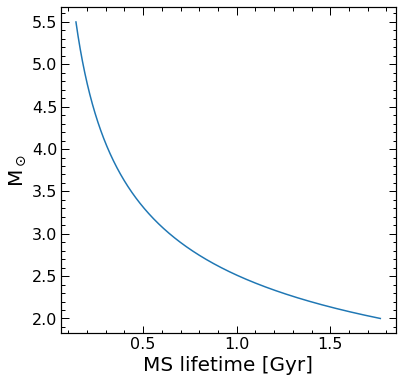

In [13]:
plt.plot(t, M)
plt.xlabel('MS lifetime [Gyr]')
plt.ylabel('M$_\odot$')
plt.show()

In [36]:
vmin = np.array([-200, -150, -150])
n = np.array([200, 150, 150])
dv = np.array([2, 2, 2])
vmax = vmin + dv*n

In [37]:
vmax

array([200, 150, 150])

In [ ]:
\begin{table}
	\label{tab:samples}
	\centering
	\caption{Vertices for the regions in  $M_G$ and $G_\mathrm{BP}-G_\mathrm{RP}$ that make up our red and blue WD sequences.}
	\begin{tabular}{l l}
		\multicolumn{2}{|c|}{\textbf{Red}} \\
		$G_\mathrm{BP}-G_\mathrm{RP}$ & $M_G$\\
		\hline
		$\mathrm{mag}$ & $\mathrm{mag}$\\
		\hline
		1.544 & 15.308  \\
		1.395 & 15.197  \\
		1.144 & 14.878  \\
		0.969 & 14.609  \\
		0.802 & 14.302  \\
		0.663 & 14.057  \\
		0.547 & 13.726  \\
		0.434 & 13.382  \\
		0.296 & 12.977  \\
		0.219 & 12.646  \\
		0.15 & 12.377   \\
		0.099 & 12.217  \\
		0.023 & 12.045  \\
		-0.065 & 11.788 \\
		-0.181 & 11.359 \\
		-0.287 & 10.844 \\
		-0.414 & 10.292 \\
		-0.112 & 10.279 \\
		0.62 & 12.511   \\
		1.468 & 14.645  \\
		&               & 0.875 & 15.7 \\
		&               & 1.475 & 15.933 \\
		&               & 1.65 & 15.308
	\end{tabular}
\end{table}